In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha

delphesDir = os.path.abspath("../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.5)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/04


# Set Delphes output files

In [2]:
inputFiles = {'Vector:(600,100)' : '../DMSimp_vector_all/Events/run_01/vector_600_100_delphes_events.root',
#              'Vector:(1200,100)' : '../DMSimp_vector_all/Events/run_04/vector_1200_100_delphes_events.root',
              'Vector:(2000,100)' : '../DMSimp_vector_all/Events/run_08/vector_2000_100_delphes_events.root',
              
             'Squark:(600,100)' : '../squarkMonojet/Events/run_01/squark_600_100_delphes_events.root',
#              'Squark:(1200,100)' : '../squarkMonojet/Events/run_04/squark_1200_100_delphes_events.root',
              'Squark:(2000,100)' : '../squarkMonojet/Events/run_08/squark_2000_100_delphes_events.root'              
             }

# Load Model Parameters

In [3]:
parameters = {}
for label,file in inputFiles.items():
    banner = list(glob.glob(os.path.dirname(file)+'/*banner.txt'))
    if len(banner) != 1:
        print('%i banner files found for %s!' %(len(banner),label))
        continue
    else:
        banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    xsecPB = eval(xroot.find('init').text.split()[-2])
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    if 'vector' in label.lower():
        mMed = pars.blocks['MASS'][55]
        mDM = pars.blocks['MASS'][52]
    elif 'pseudoscalar' in label.lower():
        mMed = pars.blocks['MASS'][54]
        mDM = pars.blocks['MASS'][52]
    elif 'squark' in label.lower():
        mMed = pars.blocks['MASS'][2000002]
        mDM = pars.blocks['MASS'][1000022]

    parameters[label] = {'xsec(pb)' : xsecPB, 'mMed' : mMed, 'mDM' : mDM}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV, cross-section = %1.3e pb' %(mMed,mDM,xsecPB))

Vector:(600,100) : mMed = 600.00 GeV, mDM = 100.00 GeV, cross-section = 9.992e+01 pb
Vector:(2000,100) : mMed = 2000.00 GeV, mDM = 100.00 GeV, cross-section = 4.608e-01 pb
Squark:(600,100) : mMed = 600.00 GeV, mDM = 100.00 GeV, cross-section = 8.128e-02 pb
Squark:(2000,100) : mMed = 2000.00 GeV, mDM = 100.00 GeV, cross-section = 1.285e-04 pb


# Load events, get parton level and detector level MET

In [4]:
pTj1 = {label : np.array([]) for label in inputFiles}
pTj2 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
genMet = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0.0 for label in inputFiles}

    
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    parameters[label]['Events'] = nevts
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        
        weight = tree.Weight.At(1).Weight # Correct weight when using matching

        totalweight[label] += weight

        missingET = tree.MissingET.At(0)
        if (tree.Jet.GetEntries() > 0):
            pTj1[label] = np.append(pTj1[label],tree.Jet.At(0).PT)
        else:
            pTj1[label] = np.append(pTj1[label],0.0)
        
        if (tree.Jet.GetEntries() > 1):
            pTj2[label] = np.append(pTj2[label],tree.Jet.At(1).PT)
        else:
            pTj2[label] = np.append(pTj2[label],0.0)

#         genMissingET = tree.GenMissingET.At(0)  # USE REAL MISSING ET!
        
#         if missingET.MET < 250.:
#             continue
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],missingET.MET)
#         genMet[label] = np.append(genMet[label],genMissingET.MET)

    f.Close()


### Total cross-sections

In [9]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb (%i events)' %(w,parameters[label]['Events']))
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(totalweight.keys())}
for label in colors:
    if 'vector' not in label.lower():
        continue
    if label.replace('Vector','Squark') not in colors:
        continue
    colors[label.replace('Vector','Squark')] = colors[label]

Vector:(600,100) total cross-section = 6.842e+01 pb (34336 events)
Vector:(2000,100) total cross-section = 3.795e-01 pb (42011 events)
Squark:(600,100) total cross-section = 8.127e-02 pb (50000 events)
Squark:(2000,100) total cross-section = 1.285e-04 pb (50000 events)


### Plot Distributions

/tmp/ipykernel_35105/1417214061.py:2: RuntimeWarning: invalid value encountered in divide
  pTratio = {label : pTj2[label]/pTj1[label] for label in pTj1}


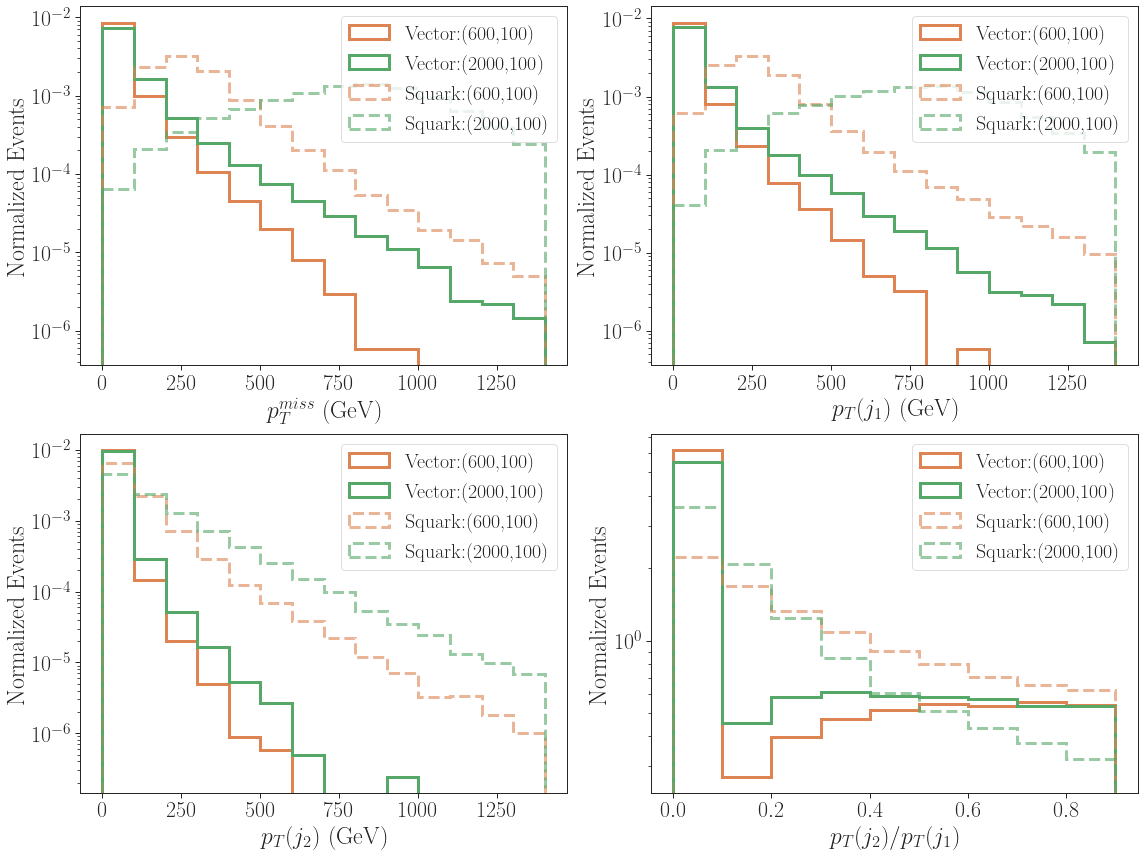

In [11]:
fig,axarr = plt.subplots(figsize=(16,12),nrows=2,ncols=2)
pTratio = {label : pTj2[label]/pTj1[label] for label in pTj1}
plots = {0: met, 1 : pTj1, 2 : pTj2, 3 : pTratio}
plotAxes = {0: r'$p_T^{miss}$ (GeV)', 1 : r'$p_T(j_1)$ (GeV)', 2 : r'$p_T(j_2)$ (GeV)', 
            3 : r'$p_T(j_2)/p_T(j_1)$'}
plotBins = {0 : np.arange(0.,1500.,100.), 1 : np.arange(0.,1500.,100.),
           2 : np.arange(0.,1500.,100.), 3 : np.arange(0.,1.,0.1)}

for iax,ax in enumerate(axarr.reshape(-1)):
    plotVar = plots[iax]
    for label,plotPts in plotVar.items():
        if 'vector' in label.lower():
            alpha = 1.0
            ls = 'solid'
        else:
            alpha = 0.6
            ls = 'dashed'
        binc,binEdges,patches = ax.hist(plotPts,bins=plotBins[iax],linestyle=ls,
                                   label=label,histtype='step',color=colors[label],
                                   weights=weights[label],linewidth=3,alpha=alpha,density=True)
    
    ax.set_yscale('log')
#     ax.set_ylim(1e-5,3e-2)
    ax.set_xlabel(plotAxes[iax])
    ax.set_ylabel('Normalized Events')
#     ax.set_xlim(0,1000)
#     ax.set_title('Vector vs Pseudoscalar')
    ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig('dists_vector_squark.png')
plt.show()